In [1]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


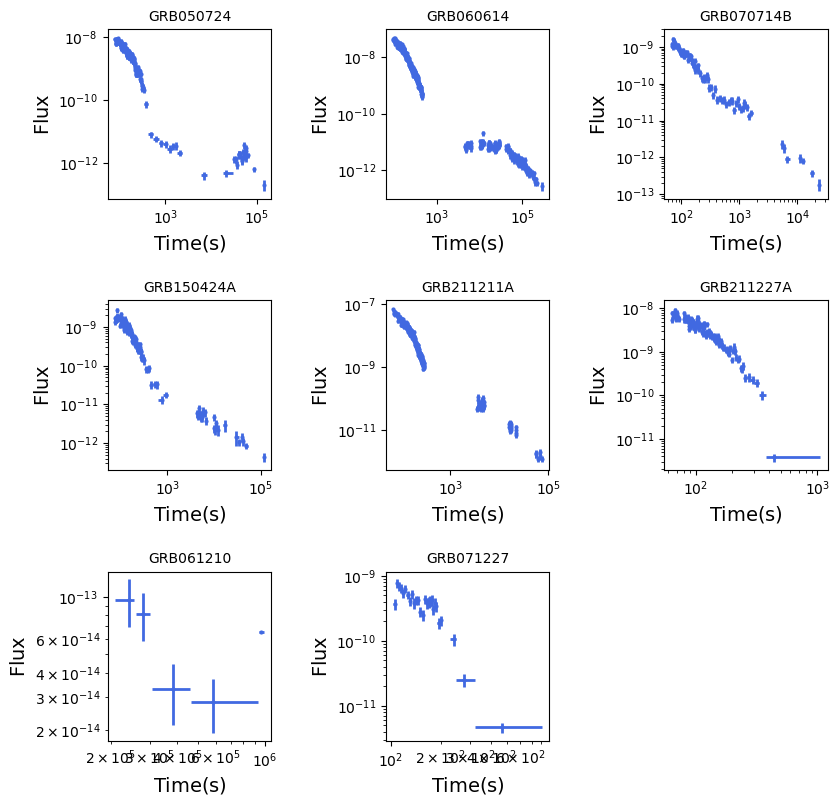

In [3]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=0

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 24
    # variables        = 4
    chi-square         = 9.07170374
    reduced chi-square = 0.45358519
    Akaike info crit   = -15.3494498
    Bayesian info crit = -10.6372344
[[Variables]]
    t_break:    57521.9736 +/- 3208.90885 (5.58%) (init = 55000)
    alpha_1:   -1.41093896 +/- 0.28753405 (20.38%) (init = -1.2)
    alpha_2:    2.97633721 +/- 0.67770145 (22.77%) (init = 2.2)
    amplitude:  1.9704e-12 +/- 1.8961e-13 (9.62%) (init = 2e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(t_break, alpha_1)   = 0.532
    C(t_break, alpha_2)   = 0.527
    C(alpha_1, alpha_2)   = 0.247
    C(alpha_2, amplitude) = -0.213
    C(alpha_1, amplitude) = 0.192
    C(t_break, amplitude) = 0.148


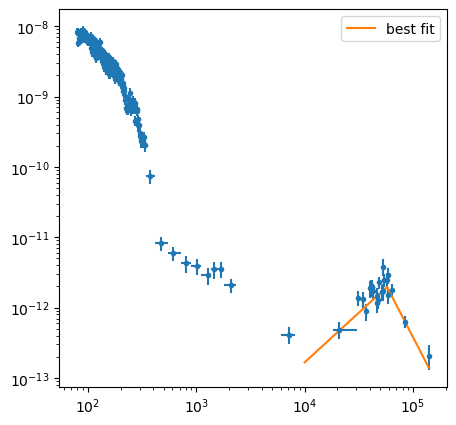

In [4]:
i=0
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 211

params=lm.Parameters()
params.add("t_break", min = 4e4, max = 6e4, value = 5.5e4)
params.add("alpha_1", min = -5.0, max = 5.0, value = -1.2)
params.add("alpha_2", min = 0, max = 5.0, value = 2.2)
params.add("amplitude", min = 8e-13, max = 1e-11, value = 2e-12)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)


x1=np.linspace(1e4,1.4e5,500)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
#plt.errorbar(time[fit_index:], flux[fit_index:], fmt='o')
#plt.plot(x1,broken_power_law(x1,55000, -1.2, 2.2, 2e-12),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [5]:
res_refined = lm.minimize(cost_func_bpl, method='emcee', burn=1000, steps=50000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)

res_refined.params.valuesdict()

100%|██████████| 50000/50000 [02:53<00:00, 288.52it/s]


{'t_break': 55807.79107629722,
 'alpha_1': -1.34006279627504,
 'alpha_2': 2.8507821727343448,
 'amplitude': 2.1110118446643104e-12}

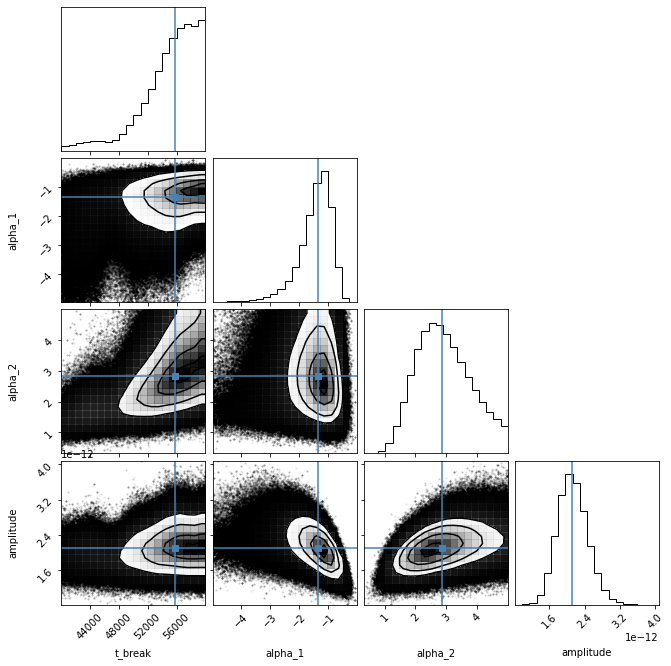

In [6]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))



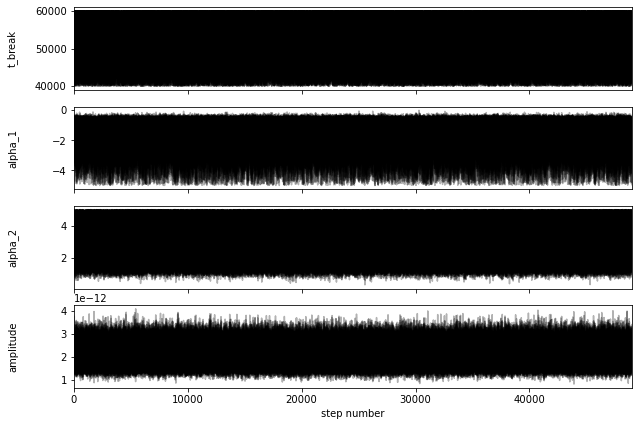

In [7]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = res_refined.chain
labels=res_refined.var_names
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


### Initial Emission

[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 573
    # data points      = 211
    # variables        = 2
    chi-square         = 602.583341
    reduced chi-square = 2.88317388
    Akaike info crit   = 225.416616
    Bayesian info crit = 232.120332
[[Variables]]
    alpha_1:    3.22825396 +/- 0.05582647 (1.73%) (init = 2.7)
    amplitude:  0.01924907 +/- 0.00532066 (27.64%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.990


<Figure size 800x800 with 0 Axes>

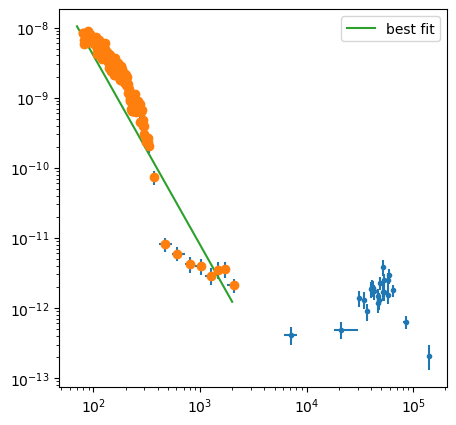

In [8]:
i=0
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 211
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 2.7)
params_ini.add("amplitude", min = 1e-6, max = 1, value = 1e-3)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="differential_evolution")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(7e1,2e3,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
plt.plot(x1,power_law(x1, 2.7, 1e-3),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [9]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 5000/5000 [00:20<00:00, 246.85it/s]


{'alpha_1': 3.234348214105112, 'amplitude': 0.019831447491550802}

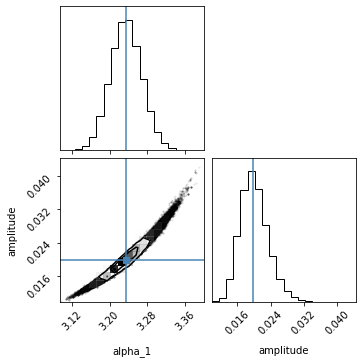

In [10]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

In [11]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 142
    # data points      = 235
    # variables        = 10
    chi-square         = 116.666558
    reduced chi-square = 0.51851803
    Akaike info crit   = -144.562412
    Bayesian info crit = -109.966556
[[Variables]]
    tb0:        264.668895 +/- 4.08006895 (1.54%) (init = 250)
    tb1:        489.505872 +/- 23.7539090 (4.85%) (init = 450)
    tb2:        11995.9312 +/- 2967.28886 (24.74%) (init = 10000)
    tb3:        58695.3346 +/- 4779.85781 (8.14%) (init = 63000)
    alpha_0:    2.07486949 +/- 0.04437669 (2.14%) (init = 2)
    alpha_1:    7.47449921 +/- 0.42697906 (5.71%) (init = 8)
    alpha_2:    1.05512162 +/- 0.16541345 (15.68%) (init = 1)
    alpha_3:   -1.28203581 +/- 0.32840403 (25.62%) (init = -1.2)
    alpha_4:    3.08082001 +/- 0.96137089 (31.21%) (init = 2.5)
    amplitude:  8.2451e-10 +/- 4.4446e-11 (5.39%) (init = 8e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(

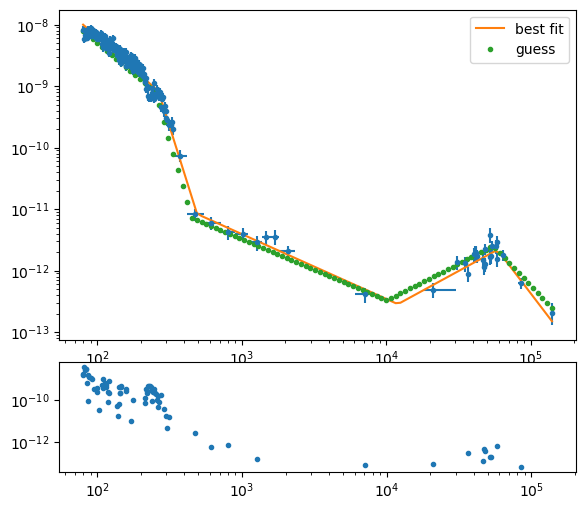

name,value,standard error,relative error,initial value,min,max,vary
tb0,264.668895,4.08006895,(1.54%),250.0,100.000000,1000.00000,True
tb1,489.505872,23.7539090,(4.85%),450.0,100.000000,1000.00000,True
tb2,11995.9312,2967.28886,(24.74%),10000.0,5000.00000,50000.0000,True
tb3,58695.3346,4779.85781,(8.14%),63000.0,40000.0000,90000.0000,True
alpha_0,2.07486949,0.04437669,(2.14%),2.0,-10.0000000,10.0000000,True
alpha_1,7.47449921,0.42697906,(5.71%),8.0,-10.0000000,20.0000000,True
alpha_2,1.05512162,0.16541345,(15.68%),1,-100.000000,100.000000,True
alpha_3,-1.28203581,0.32840403,(25.62%),-1.2,-5.00000000,0.00000000,True
alpha_4,3.08082001,0.96137089,(31.21%),2.5,0.00000000,10.0000000,True
amplitude,8.2451e-10,4.4446e-11,(5.39%),8e-10,1.0000e-10,5.0000e-09,True


In [78]:
i=0
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=5
params=lm.Parameters()
params.add("tb0", min = 1e2, max = 1e3, value = 2.5e2)
params.add("tb1", min = 1e2, max = 1e3, value = 4.5e2)
# params.add("tb2", min = 1e3, max = 5e3, value = 2e3)
params.add("tb2", min = 5e3, max = 5e4, value = 1e4)
params.add("tb3", min = 4e4, max = 9e4, value = 6.3e4)
params.add("alpha_0", min = -10, max = 10.0, value = 2.0)
params.add("alpha_1", min = -10, max = 20.0, value = 8.0)
params.add("alpha_2", min = -100, max = 100, value = 1)
# params.add("alpha_3", min = -100, max = 100, value = 1.4)
params.add("alpha_3", min = -5.0, max = 0, value = -1.2)
params.add("alpha_4", min = 0, max = 10.0, value = 2.5)
params.add("amplitude", min = 1e-10, max = 5e-9, value = 8e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [2.5e2, 5e2, 2e3, 1.5e4, 5.5e4], [2, 8.0, -0.2, 1.4, -2.2, 3.0], 8e-11),'.',label ='guess')
ax1.loglog(x, nbroken_law(x, [2.5e2, 4.5e2, 1e4, 5.5e4], [2, 8.0, 1, -1.2, 2.5], 8e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params